# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

-  `alldata.xlsx`: Contains responses from both TV stations.
-  `drdata.xlsx`: Contains responses from DR.
-  `drq.xlsx`: Contains questions from DR.
-  `tv2data.xlsx`: Contains responses from TV2.
-  `tv2q.xlsx`: Contains questions from TV2.
-  `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a _minimum_, your analysis should include:

-  An analysis/description of which questions are most crucial concerning their placement on the axes.
-  Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
-  A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
-  An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
-  Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter |       Party name        |    Party name (English)     | Political position |
| :----------: | :---------------------: | :-------------------------: | :----------------: |
|      A       |    Socialdemokratiet    |      Social Democrats       |    Centre-left     |
|      V       |         Venstre         |    Danish Liberal Party     |    Centre-right    |
|      M       |       Moderaterne       |          Moderates          |    Centre-right    |
|      F       | Socialistisk Folkeparti |  Socialist People's Party   |     Left-wing      |
|      D       |  Danmarksdemokraterne   |      Denmark Democrats      |     Right-wing     |
|      I       |    Liberal Alliance     |      Liberal Alliance       |     Right-wing     |
|      C       |      Konservative       | Conservative People's Party |     Right-wing     |
|      Æ       |      Enhedslisten       |     Red-Green Alliance      |      Far-left      |
|      B       |    Radikale Venstre     |    Social Liberal Party     |    Centre-left     |
|      D       |     Nye Borgerlige      |          New Right          |     Far-right      |
|      Z       |      Alternativet       |       The Alternative       |    Centre-left     |
|      O       |    Dansk Folkeparti     |    Danish People's Party    |     Far-right      |
|      G       |       Frie Grønne       |         Free Greens         |    Centre-left     |
|      K       |   Kristendemokraterne   |     Christian Democrats     |    Centre-right    |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)

Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

-  [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
-  [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
-  [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)


In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from sklearn.manifold import TSNE

/var/folders/tr/6j3q6wwn3x30xdy23r67tp100000gn/T/ipykernel_12259/1113799509.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Load the data and remove the unnecessary columns.


In [3]:
data = pd.read_excel("alldata.xlsx")
data = data.drop(columns="alder")
data = data.drop(columns="storkreds")
print(data.columns)

Index(['530', '531', '533', '534', '535', '537', '538', '540', '541', '543',
       '544', '545', '546', '547', '548', '550', '551', '552', '553', '555',
       '556', '557', '559', '561', '563', 'navn', 'parti', '1a', '1b', '2a',
       '2b', '3a', '3b', '4a', '4b', '5a', '5b', '6a', '6b', '7a', '7b', '8a',
       '8b', '9a', '9b', '10a', '10b', '11a', '11b', '12a', '12b'],
      dtype='object')


Move the candidate's name and party to the end of the dataframe for easier selection of question data.


In [4]:
parti_col = data["parti"]
navn_col = data["navn"]
# Drop the columns 'parti' and 'navn'
data.drop(columns=["parti", "navn"], inplace=True)

# Append the columns 'parti' and 'navn' to the end of the DataFrame
data["parti"] = parti_col
data["navn"] = navn_col
print(data.head())

   530  531  533  534  535  537  538  540  541  543  ...  9a  9b  10a  10b  \
0   -1   -2    1   -2    2    1   -2    1    1    2  ...   2   0    1   -2   
1    2    2   -1   -2   -1   -2    1   -2    2   -2  ...  -2   0   -1    2   
2    2    1   -2   -2    1   -2    1   -1    1   -1  ...  -1  -2    0    2   
3    2    1   -2   -1    1    1    1    1    1   -2  ...  -2   2    2    2   
4    1    1   -2    2   -2    1   -2    1    2   -2  ...  -2   0   -1    0   

   11a  11b  12a  12b                    parti                      navn  
0   -2    1    1    1              Moderaterne      Lars Philipsen Prahm  
1    1   -2    0    0  Socialistisk Folkeparti             Karsten Hønge  
2    0   -1    1   -2             Alternativet  Martin Kelleher-Petersen  
3    2   -1    2    0             Alternativet    Nicklas Gjedsig Larsen  
4   -2    0    2   -2                Løsgænger            Tom Gillesberg  

[5 rows x 51 columns]


Extract only the question data into a separate dataframe and print.


In [5]:
pd.set_option(
    "display.max_columns", None
)  # This line will ensure all columns are displayed
index_of_parti = data.columns.get_loc("parti")
print(index_of_parti)
questions_data = data.iloc[:, :49]
print(questions_data.head())

49
   530  531  533  534  535  537  538  540  541  543  544  545  546  547  548  \
0   -1   -2    1   -2    2    1   -2    1    1    2   -2    1    2    2    1   
1    2    2   -1   -2   -1   -2    1   -2    2   -2    2   -1   -2   -2    2   
2    2    1   -2   -2    1   -2    1   -1    1   -1    2   -2   -2   -1    1   
3    2    1   -2   -1    1    1    1    1    1   -2    2    1    1   -2    2   
4    1    1   -2    2   -2    1   -2    1    2   -2   -2    2    2   -2    2   

   550  551  552  553  555  556  557  559  561  563  1a  1b  2a  2b  3a  3b  \
0   -2    1    2   -2    2    2    1    2    2   -2   0   0   2   2   2  -2   
1    2   -2    1    1   -1   -2    1    2    1    2   1   1   1   1   1   2   
2    1   -2    2   -1   -2   -1    1    2    2    2   1   1   1   2   1   1   
3    2   -2    2    1    2   -2    2    2    2    2   2   2   2   2   0   2   
4    1   -2    2   -2   -2   -1    1   -2   -1   -2  -2  -2   0   0  -2  -2   

   4a  4b  5a  5b  6a  6b  7a  7b  8a  8b

Scale the data using the standard scaler (mean of 0 with variance of 1) and apply PCA without specifying the number of components in order to see the variance explained by each component.
We can observe that the first two components explain about 51% of the variance.


In [6]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(questions_data)

pca = PCA(n_components=None)
principal_components = pca.fit_transform(data_scaled)
print(pca.explained_variance_ratio_)

[0.41737636 0.10259865 0.04976015 0.04300927 0.0293233  0.0237033
 0.01994712 0.01697463 0.01676652 0.01608279 0.01527152 0.01449084
 0.01303718 0.01297392 0.01200226 0.01125725 0.0102922  0.00997773
 0.00986747 0.00966786 0.00928391 0.0089641  0.00877818 0.00786085
 0.00755989 0.00722701 0.00682415 0.00670982 0.00626662 0.00605007
 0.00582534 0.0055948  0.0052595  0.00505699 0.00473416 0.00466639
 0.00453667 0.00416406 0.00398844 0.00388108 0.00341904 0.00330379
 0.0029882  0.00290354 0.00251036 0.00244041 0.00210387 0.00141116
 0.00130729]


Specify the number of components, show the shape of the data, and plot the elbow graph.


[0.41737636 0.10259865 0.04976013 0.04300926 0.02932258 0.02369782
 0.01992727 0.01682296 0.01669915 0.0159969 ]
Original shape: (867, 49)
Reduced shape: (867, 10)


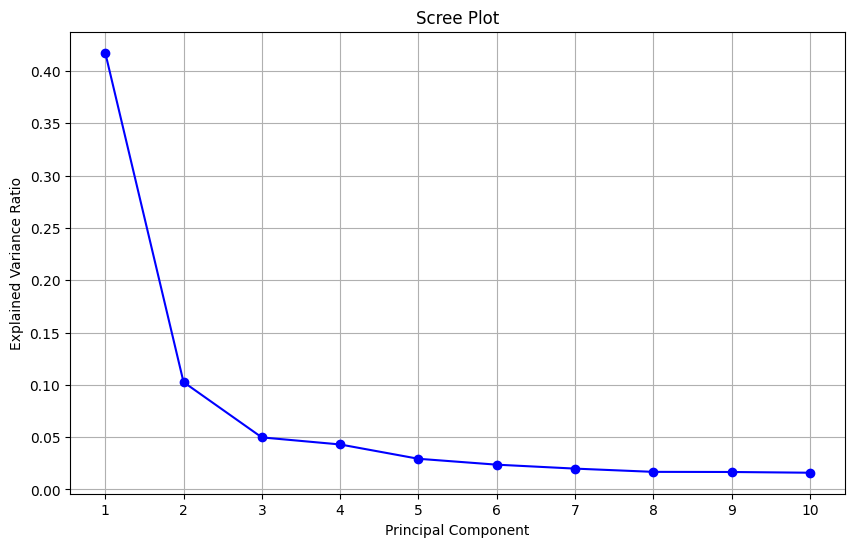

In [7]:
pca = PCA(n_components=10)
principal_components = pca.fit_transform(data_scaled)
print(pca.explained_variance_ratio_)

print("Original shape: {}".format(str(data_scaled.shape)))
print("Reduced shape: {}".format(str(principal_components.shape)))

# Creating the plot
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, 1 + len(pca.explained_variance_ratio_)),
    pca.explained_variance_ratio_,
    marker="o",
    linestyle="-",
    color="b",
)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, 11))  # Ensuring that all components are marked on the x-axis
plt.grid(True)
plt.show()

Based on the information in the elbow graph, we pick two principal components for the analysis.


[0.41737636 0.10259865]
Original shape: (867, 49)
Reduced shape: (867, 2)


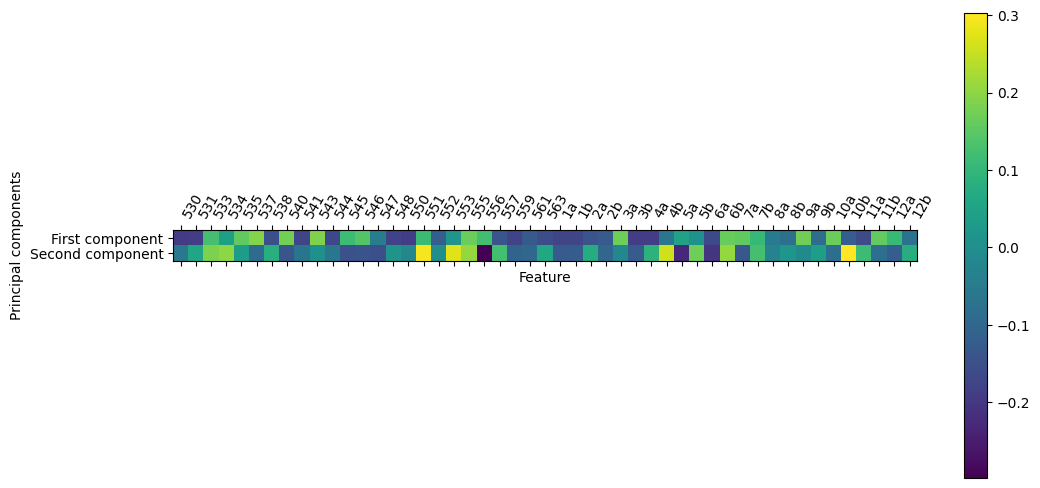

In [8]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(data_scaled)
print(pca.explained_variance_ratio_)

print("Original shape: {}".format(str(data_scaled.shape)))
print("Reduced shape: {}".format(str(principal_components.shape)))

# Create a heatmap of the loading vectors
plt.figure(figsize=(12, 6))
plt.matshow(pca.components_, cmap="viridis", fignum=1)
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(
    range(len(questions_data.columns)), questions_data.columns, rotation=60, ha="left"
)
plt.xlabel("Feature")
plt.ylabel("Principal components")
plt.show()

In [9]:
drq_questions = pd.read_excel("drq.xlsx")
tv2_questions = pd.read_excel("tv2q.xlsx")

# Remove the first 51 elements from tv2_questions
tv2_questions = tv2_questions.iloc[50:]

combined_questions = pd.concat(
    [
        drq_questions[["ID", "Title", "Question"]],
        tv2_questions[["id", "header", "question"]].rename(
            columns={"id": "ID", "header": "Title", "question": "Question"}
        ),
    ]
)
# Print all combined questions
pd.set_option("display.max_rows", None)  # This line will ensure all rows are displayed
pd.set_option(
    "display.max_columns", None
)  # This line will ensure all columns are displayed

combined_questions.to_excel("combined_questions.xlsx", index=False)
# print(combined_questions)

# Access the loading vectors
loadings = pca.components_
# print(loadings)

# set the ID column of combined questions as string
combined_questions.ID = combined_questions.ID.astype(str)

# Create a dictionary to store loadings for each component
loading_dict = {}
for i, component in enumerate(loadings):
    # Create a list to store tuples of feature loading pairs
    loadings_list = [
        (feature, loading)
        for feature, loading in zip(questions_data.columns, component)
    ]
    # Sort the list based on loading value
    sorted_loadings = sorted(loadings_list, key=lambda x: x[1], reverse=True)
    # Store the sorted loadings in the dictionary
    loading_dict["Component {}".format(i + 1)] = sorted_loadings

# Print the questions ordered by loading to each component
for component, loadings_list in loading_dict.items():
    print(component + ":")
    for feature, loading in loadings_list[:10]:  # Only take the top 10
        loading = round(loading, 5)  # Round the loading to 5 decimal points
        question_text = (
            combined_questions[combined_questions["ID"] == feature]["Question"].values[
                0
            ]
            if feature in combined_questions["ID"].values
            else "No question found"
        )
        print("\t{}: {}\t{}".format(feature, loading, question_text))

Component 1:
	537: 0.19028	Det er okay, at den økonomiske ulighed stiger, så længe danskerne generelt bliver rigere
	543: 0.18589	Det er en god idé, at dagpengesatsen for nyuddannede er sat ned
	540: 0.1744	Det skal være muligt at tjene penge på at drive private børnehaver og vuggestuer
	9a: 0.17269	Dele af SU’en på videregående uddannelser skal omdannes til lån for at sikre ressourcer til andre dele af uddannelsesområdet.
	3a: 0.17047	Danmark bør bruge to procent af BNP på forsvaret, inden 2033 begynder.
	555: 0.16574	Asylansøgere bør sendes til et land uden for EU - f.eks. Rwanda - mens deres ansøgning behandles
	10a: 0.16568	Det offentlige bruger i dag for mange penge på at hjælpe mennesker, der godt kunne klare sig selv, og for få penge på mennesker, der virkelig har brug for hjælp.
	6b: 0.16321	Det vil være en god idé at etablere et dansk asylmodtagecenter i Rwanda.
	11b: 0.15866	Det bør undersøges, om Mette Frederiksen kan stilles for en rigsret som konsekvens af hendes håndterin

**Component 1:**

| Item | Loading | Question                                                                                                                                                |
| ---- | ------- | ------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 537  | 0.19028 | It is okay for economic inequality to increase as long as the Danes generally become richer                                                             |
| 543  | 0.18589 | It is a good idea that the allowance rate for new graduates has been reduced                                                                            |
| 540  | 0.17440 | It must be possible to make money from running private kindergartens and nurseries                                                                      |
| 9a   | 0.17269 | Parts of the SU in higher education must be converted into loans in order to secure resources for other parts of the education area                     |
| 3a   | 0.17047 | Denmark should spend two percent of GDP on defense before 2033 begins                                                                                   |
| 555  | 0.16574 | Asylum seekers should be sent to a country outside the EU - e.g. Rwanda - while their application is being processed                                    |
| 10a  | 0.16568 | The public sector today spends too much money on helping people who could manage well on their own, and too little money on people who really need help |
| 6b   | 0.16321 | It would be a good idea to establish a Danish asylum reception center in Rwanda                                                                         |
| 11b  | 0.15866 | It should be investigated whether Mette Frederiksen can be impeached as a consequence of her handling of the Mink case                                  |
| 7a   | 0.15516 | Introduction of nuclear power in Denmark will be a good contribution to the green transition                                                            |

**Component 2:**

| Item | Loading | Question                                                                                                                                                             |
| ---- | ------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 10b  | 0.30292 | The so-called Arne pension, which allows for an earlier pension, must be maintained, even if there is a shortage of labour                                           |
| 551  | 0.29384 | There must be permanent border control between Denmark and Germany                                                                                                   |
| 553  | 0.27281 | More education places must be moved from the big cities                                                                                                              |
| 4b   | 0.25845 | The state should compensate the Danes to a greater extent for the rising prices that inflation has brought about                                                     |
| 6b   | 0.20771 | It would be a good idea to establish a Danish asylum reception center in Rwanda                                                                                      |
| 555  | 0.20675 | Asylum seekers should be sent to a country outside the EU - e.g. Rwanda - while their application is being processed                                                 |
| 534  | 0.20145 | In the long term, Denmark must be declared out of the EU                                                                                                             |
| 533  | 0.18496 | Crime committed in vulnerable residential areas must be punished particularly harshly                                                                                |
| 5b   | 0.17042 | Extra resources should be added to care for the elderly, even if this will result in other welfare areas receiving fewer resources                                   |
| 7b   | 0.12597 | Denmark must as soon as possible become totally independent of Russian gas and oil, even if this entails increased use of coal, which is more harmful to the climate |


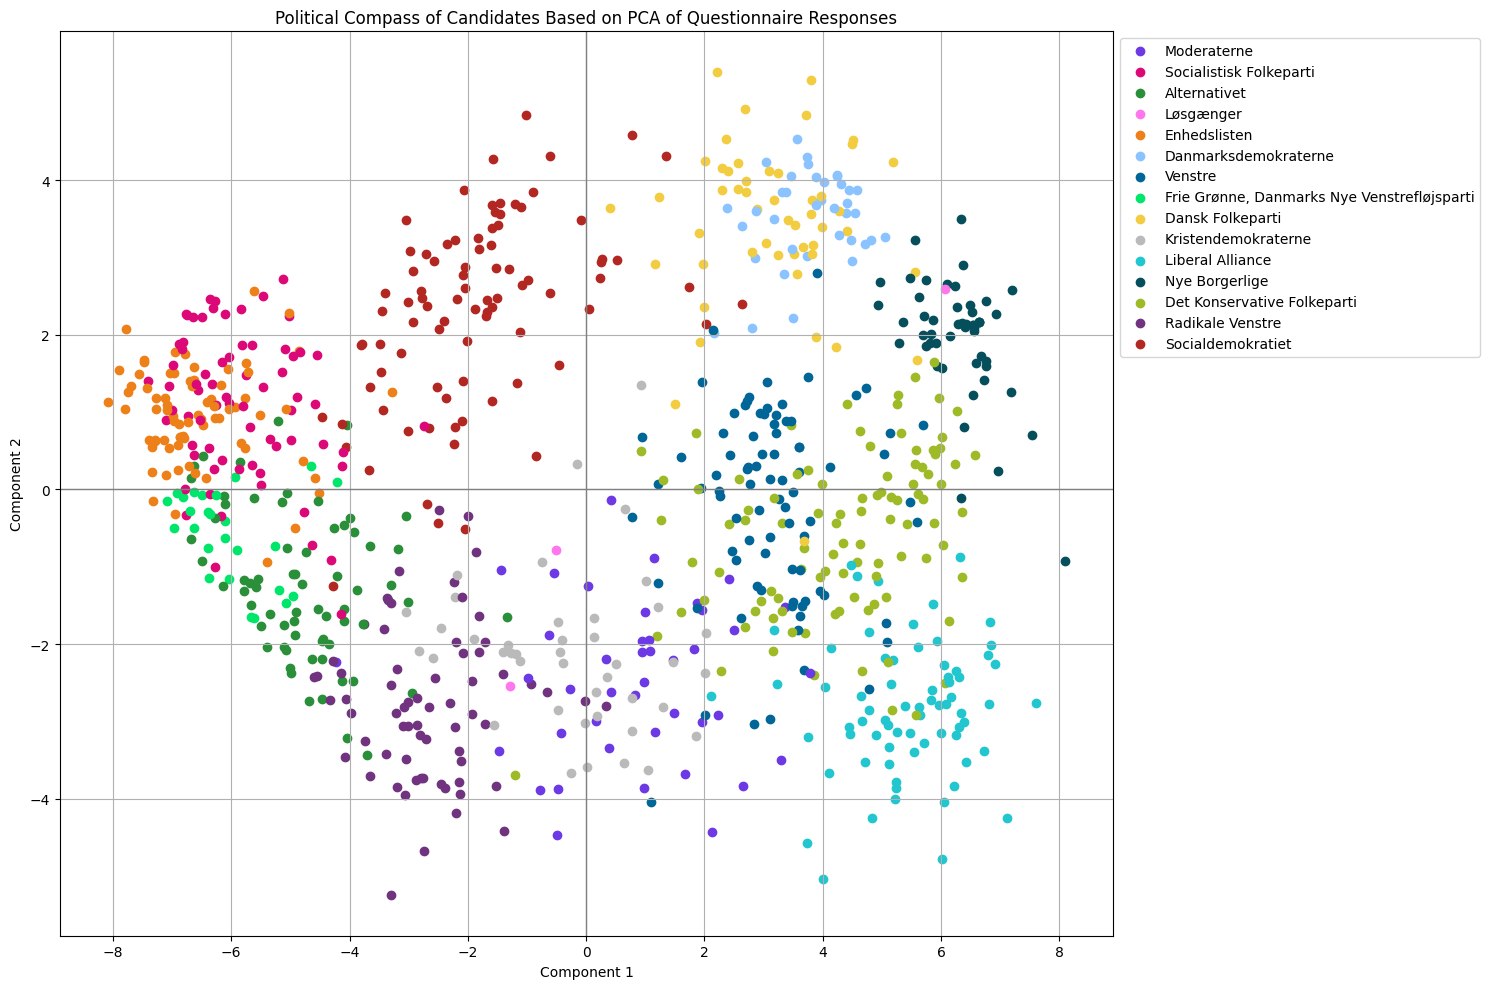

In [10]:
# Define party colors using RGB values
party_colors = {
    "Socialdemokratiet": "rgb(179, 39, 34)",
    "Venstre": "rgb(0, 102, 151)",
    "Moderaterne": "rgb(108, 57, 229)",
    "Socialistisk Folkeparti": "rgb(221, 8, 120)",
    "Danmarksdemokraterne": "rgb(138, 195, 255)",
    "Liberal Alliance": "rgb(33, 198, 207)",
    "Det Konservative Folkeparti": "rgb(158, 186, 39)",
    "Enhedslisten": "rgb(237, 128, 25)",
    "Radikale Venstre": "rgb(113, 50, 128)",
    "Nye Borgerlige": "rgb(5, 79, 92)",
    "Alternativet": "rgb(42, 143, 57)",
    "Dansk Folkeparti": "rgb(243, 205, 65)",
    "Frie Grønne, Danmarks Nye Venstrefløjsparti": "rgb(0, 230, 106)",
    "Kristendemokraterne": "rgb(186, 186, 186)",
    "Løsgænger": "rgb(255, 118, 237)",
}


# Plot the candidates on the political compass
plt.figure(figsize=(15, 10))


# Plot each candidate, coloring by party
for i, (x, y) in enumerate(principal_components):
    party = parti_col[i]
    rgb = party_colors[party][4:-1].split(",")
    color_tuple = (int(rgb[0]) / 255, int(rgb[1]) / 255, int(rgb[2]) / 255)
    plt.scatter(x, y, color=color_tuple, label=party)

# Create the legend without duplicates, and move it outside the plot area
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper left", bbox_to_anchor=(1, 1))

plt.axhline(0, color="grey", lw=1)
plt.axvline(0, color="grey", lw=1)
plt.grid(True)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title("Political Compass of Candidates Based on PCA of Questionnaire Responses")

plt.tight_layout()  # Adjust subplot params so that the subplot(s) fits in to the figure area.
plt.show()

In [11]:
# Convert the PCA components to a DataFrame for use with Plotly
principal_df = pd.DataFrame(
    principal_components, columns=["Component 1", "Component 2"]
)

data = pd.read_excel("alldata.xlsx")

# Add candidate names and parties to this DataFrame
principal_df["Candidate"] = navn_col
principal_df["Party"] = parti_col
principal_df["Age"] = data["alder"]
principal_df["Constituency"] = data["storkreds"]

# Use Plotly Express to create the scatter plot
fig = px.scatter(
    principal_df,
    x="Component 1",
    y="Component 2",
    color="Party",
    hover_data=[
        "Candidate",
        "Party",
        "Age",
        "Constituency",
    ],  # configure hover information
    title="Political Compass of Candidates",
    color_discrete_map=party_colors,
)  # map party colors to the ones defined earlier

# Improve layout
fig.update_traces(
    marker=dict(
        size=10, line=dict(width=1, color="DarkSlateGrey")
    ),  # Customize point appearance
    textposition="top center",
)
fig.update_layout(
    showlegend=True,  # Show legend
    legend_title_text="Party",  # Legend title
    hovermode="closest",  # Hover only over the closest point
    height=800,
    width=1200,
)  # Adjust the size of the plot

# Show figure
fig.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/plotly/express/_core.py:2065: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  sf: grouped.get_group(s if len(s) > 1 else s[0])


In [12]:
from IPython.display import display, HTML

# Define the table
table = """
<table>
<tr><th>Party letter</th><th>Party name</th><th>Party name (English)</th><th>Political position</th><th>Color</th></tr>
<tr><td>A</td><td>Socialdemokratiet</td><td>Social Democrats</td><td>Centre-left</td><td style="background-color:rgb(179, 39, 34)"></td></tr>
<tr><td>V</td><td>Venstre</td><td>Danish Liberal Party</td><td>Centre-right</td><td style="background-color:rgb(0, 102, 151)"></td></tr>
<tr><td>M</td><td>Moderaterne</td><td>Moderates</td><td>Centre-right</td><td style="background-color:rgb(108, 57, 229)"></td></tr>
<tr><td>F</td><td>Socialistisk Folkeparti</td><td>Socialist People's Party</td><td>Left-wing</td><td style="background-color:rgb(221, 8, 120)"></td></tr>
<tr><td>D</td><td>Danmarksdemokraterne</td><td>Denmark Democrats</td><td>Right-wing</td><td style="background-color:rgb(138, 195, 255)"></td></tr>
<tr><td>I</td><td>Liberal Alliance</td><td>Liberal Alliance</td><td>Right-wing</td><td style="background-color:rgb(33, 198, 207)"></td></tr>
<tr><td>C</td><td>Det Konservative Folkeparti</td><td>Conservative People's Party</td><td>Right-wing</td><td style="background-color:rgb(158, 186, 39)"></td></tr>
<tr><td>Æ</td><td>Enhedslisten</td><td>Red-Green Alliance</td><td>Far-left</td><td style="background-color:rgb(237, 128, 25)"></td></tr>
<tr><td>B</td><td>Radikale Venstre</td><td>Social Liberal Party</td><td>Centre-left</td><td style="background-color:rgb(113, 50, 128)"></td></tr>
<tr><td>D</td><td>Nye Borgerlige</td><td>New Right</td><td>Far-right</td><td style="background-color:rgb(5, 79, 92)"></td></tr>
<tr><td>Z</td><td>Alternativet</td><td>The Alternative</td><td>Centre-left</td><td style="background-color:rgb(42, 143, 57)"></td></tr>
<tr><td>O</td><td>Dansk Folkeparti</td><td>Danish People's Party</td><td>Far-right</td><td style="background-color:rgb(243, 205, 65)"></td></tr>
<tr><td>G</td><td>Frie Grønne, Danmarks Nye Venstrefløjsparti</td><td>Free Greens</td><td>Centre-left</td><td style="background-color:rgb(0, 230, 106)"></td></tr>
<tr><td>K</td><td>Kristendemokraterne</td><td>Christian Democrats</td><td>Centre-right</td><td style="background-color:rgb(186, 186, 186)"></td></tr>
<tr><td>L</td><td>Løsgænger</td><td>No party</td><td>---</td><td style="background-color:rgb(255, 118, 237)"></td></tr>
</table>
"""

# Display the table
display(HTML(table))

Party letter,Party name,Party name (English),Political position,Color
A,Socialdemokratiet,Social Democrats,Centre-left,
V,Venstre,Danish Liberal Party,Centre-right,
M,Moderaterne,Moderates,Centre-right,
F,Socialistisk Folkeparti,Socialist People's Party,Left-wing,
D,Danmarksdemokraterne,Denmark Democrats,Right-wing,
I,Liberal Alliance,Liberal Alliance,Right-wing,
C,Det Konservative Folkeparti,Conservative People's Party,Right-wing,
Æ,Enhedslisten,Red-Green Alliance,Far-left,
B,Radikale Venstre,Social Liberal Party,Centre-left,
D,Nye Borgerlige,New Right,Far-right,


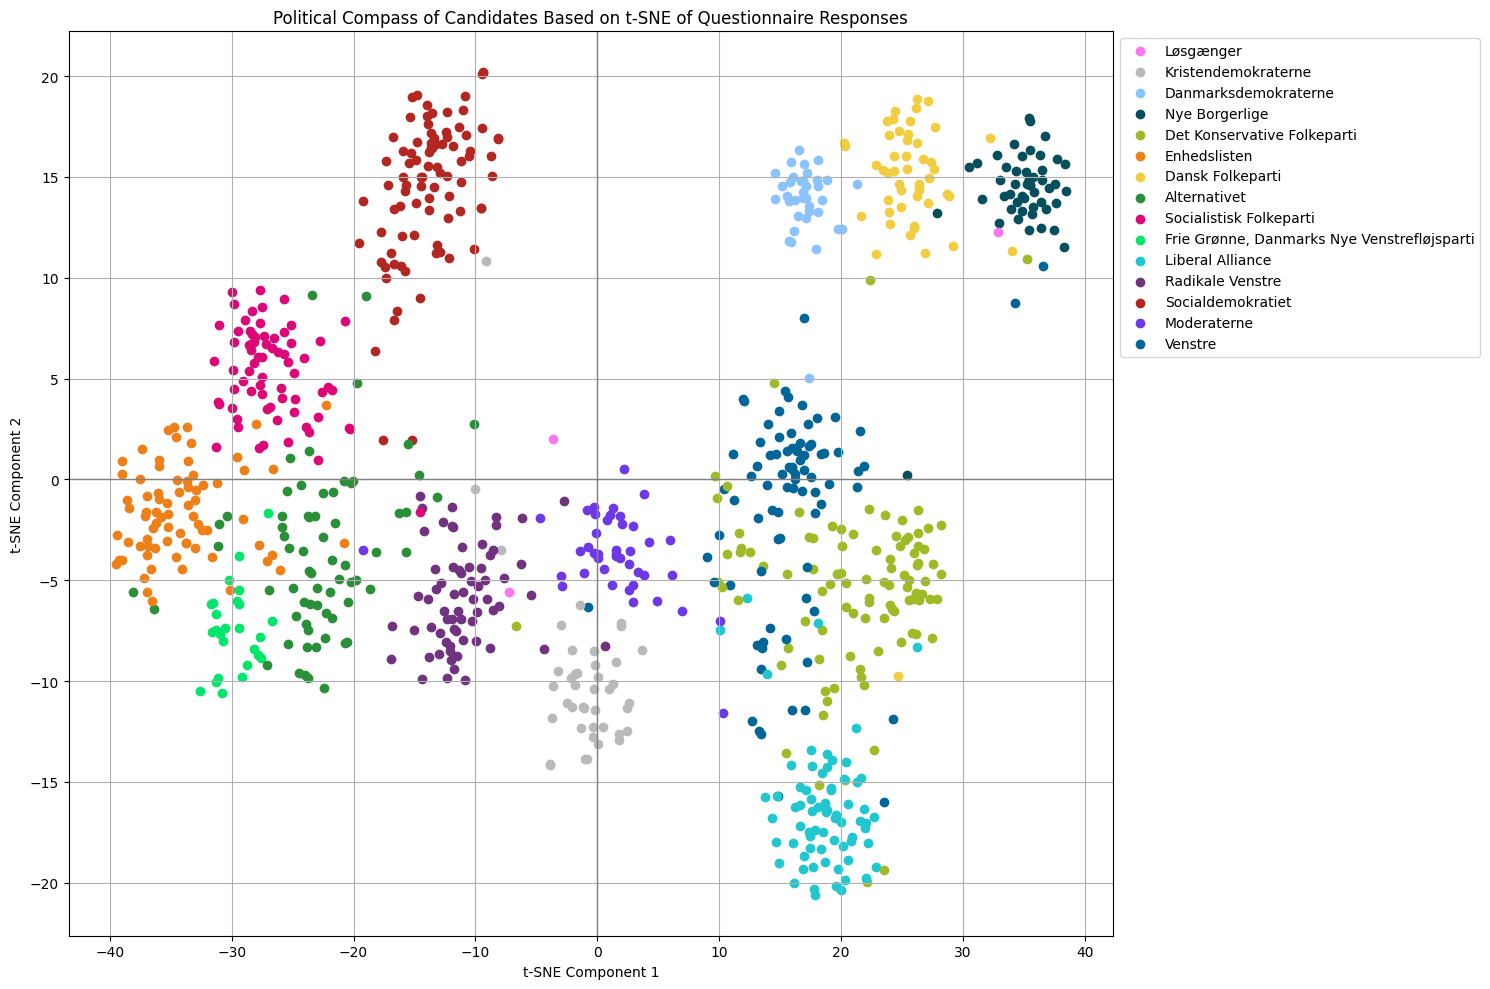

In [13]:
parties = parti_col
names = navn_col

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(data_scaled)

# Plot the candidates using t-SNE results
plt.figure(figsize=(15, 10))

# Create a dictionary to map each party to a matplotlib color
for i, (x, y) in enumerate(tsne_results):
    party = parties[i]
    rgb = party_colors[party][4:-1].split(",")
    color_tuple = (int(rgb[0]) / 255, int(rgb[1]) / 255, int(rgb[2]) / 255)
    plt.scatter(x, y, color=color_tuple, label=party)

# Create the legend without duplicates, and move it outside the plot area
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(set(labels))  # Remove duplicates in label list
unique_handles = [
    handles[labels.index(label)] for label in unique_labels
]  # Get the handles for unique labels
plt.legend(unique_handles, unique_labels, loc="upper left", bbox_to_anchor=(1, 1))

plt.axhline(0, color="grey", lw=1)
plt.axvline(0, color="grey", lw=1)
plt.grid(True)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Political Compass of Candidates Based on t-SNE of Questionnaire Responses")

plt.tight_layout()  # Adjust subplot params so that the subplot(s) fits in to the figure area.
plt.show()

<h1>Now let's look at the clustering</h1>


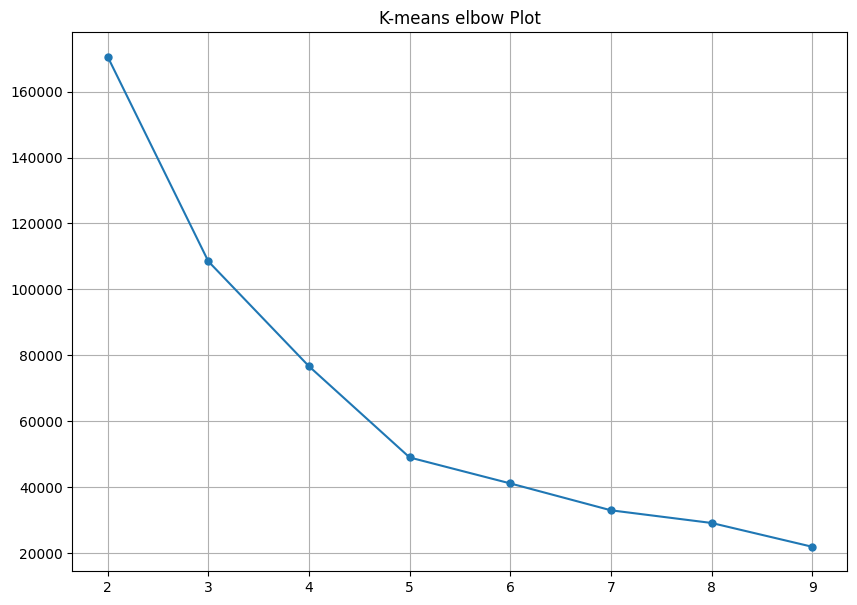

In [14]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN


plt.figure(figsize=(10, 7))

costs = []
ks = range(2, 10)
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(tsne_results)
    costs.append(kmeans.inertia_)

plt.plot(ks, costs, ".-", markersize=10)
plt.title("K-means elbow Plot")
plt.grid(True)
plt.show()

According to the elbow chart, it seems that 5 clusters is a good option for our data. However we know that there is total 14 parties (excluding 3 people with no party), so we will do KMeans with 14 clusters to see if it can find the parties clusters.


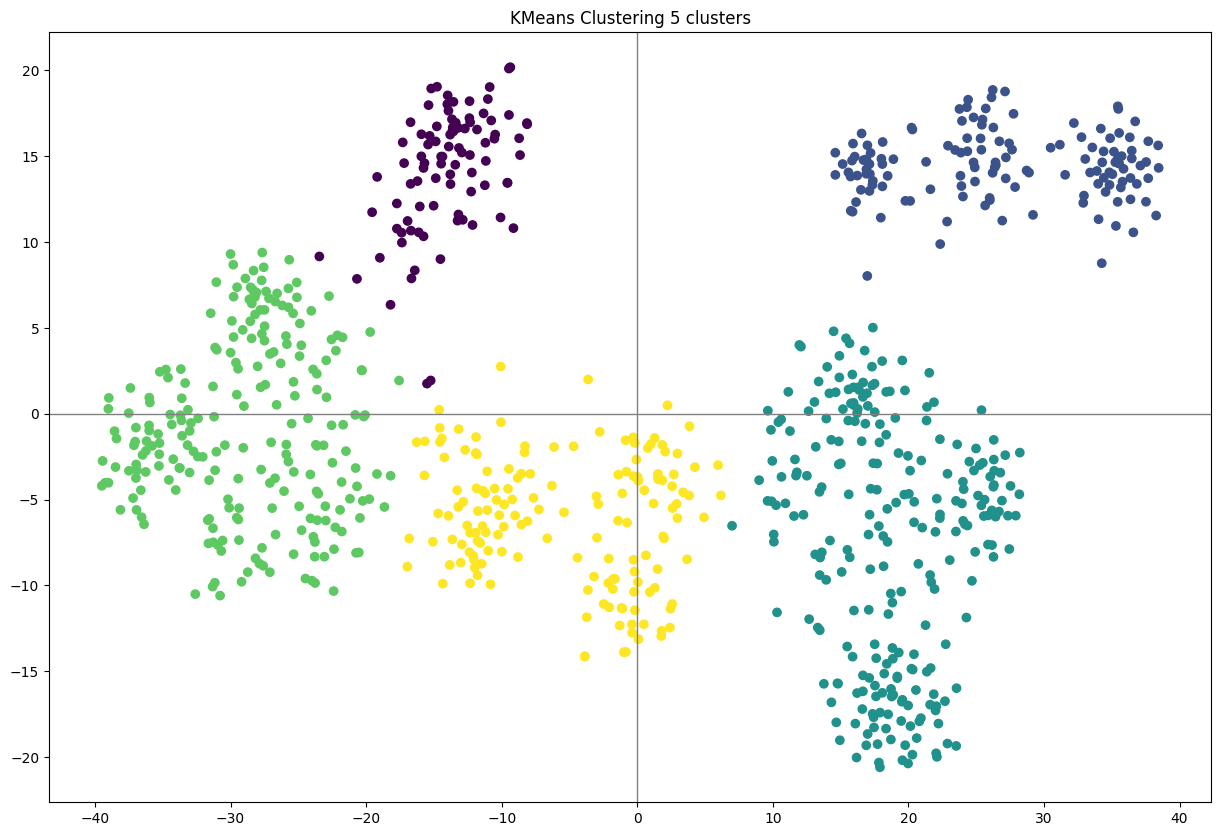

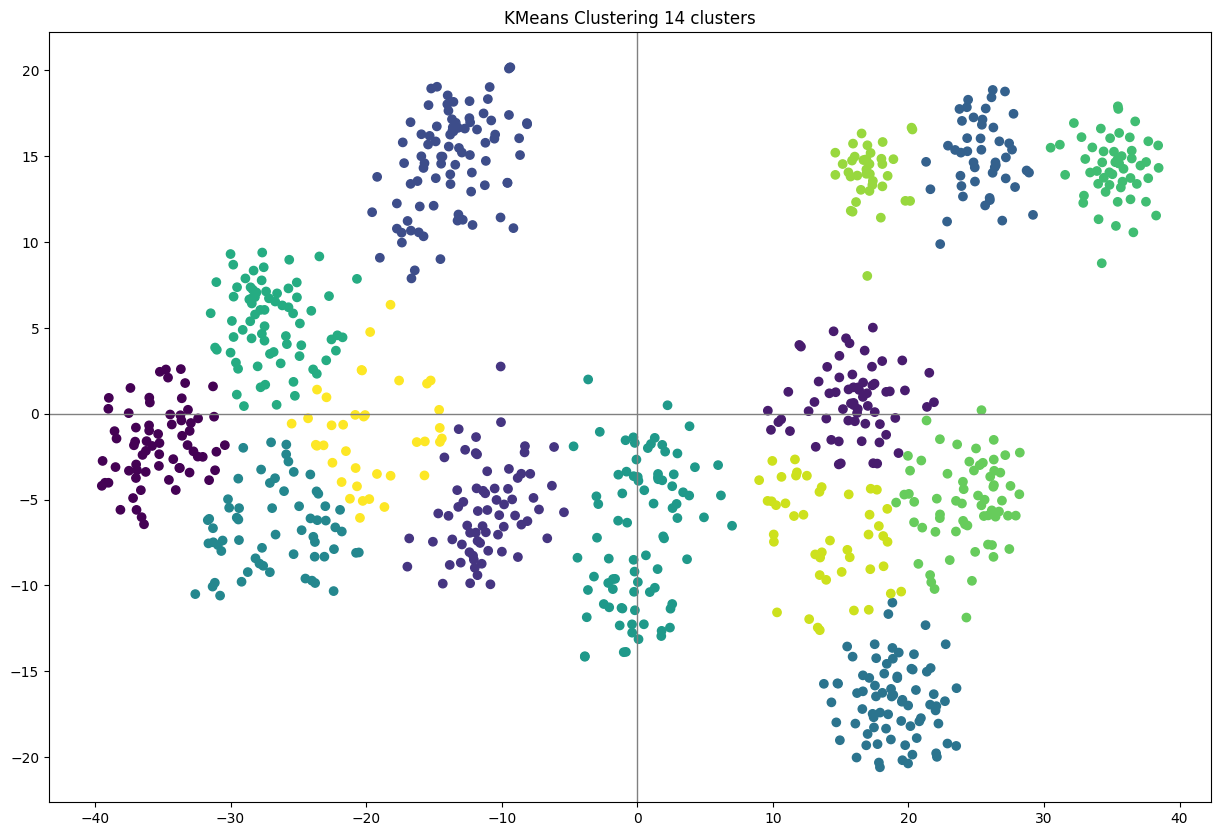

In [20]:
kmeans = KMeans(n_clusters=5)
label = kmeans.fit_predict(tsne_results)

plt.figure(figsize=(15, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label, cmap="viridis")
plt.title("KMeans Clustering 5 clusters")

plt.axhline(0, color="grey", lw=1)
plt.axvline(0, color="grey", lw=1)
plt.show()

kmeans = KMeans(n_clusters=14)
label = kmeans.fit_predict(tsne_results)

plt.figure(figsize=(15, 10))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label, cmap="viridis")
plt.title("KMeans Clustering 14 clusters")

plt.axhline(0, color="grey", lw=1)
plt.axvline(0, color="grey", lw=1)
plt.show()

As we can see, with 14 clusters it found the parties pretty well, even where they were groupped. However, KMeans cannot handle the outliers, which in this case could be an advantage.


<h2>DBSCAN</h2>


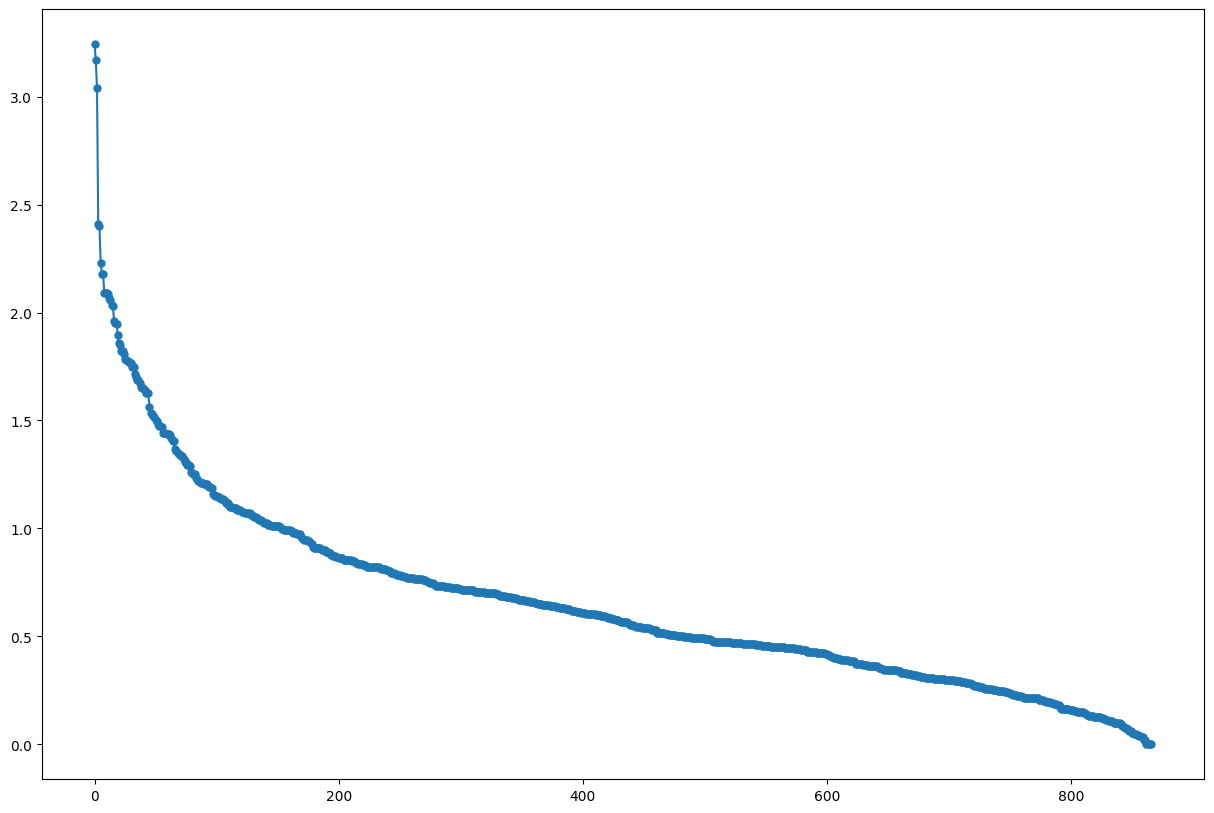

In [16]:
def calculate_k_distance(X, k):
    k_distance = []
    for i in range(len(X)):
        dist = []
        for j in range(len(X)):
            dist.append(np.linalg.norm(X[i, :] - X[j, :]))
        dist.sort()
        k_distance.append(dist[k])
    k_distance.sort(reverse=True)
    return k_distance


k = 1
k_distances = calculate_k_distance(tsne_results, k)

plt.figure(figsize=(15, 10))
plt.plot(range(len(tsne_results)), k_distances, ".-", markersize=10)
plt.show()

According to elbow chart epsilon could be between 2.2 and 2.5, after playing with the value, the optimal epsilon is 2.4 and min_samples could be 4, because the dimensionality is 2.


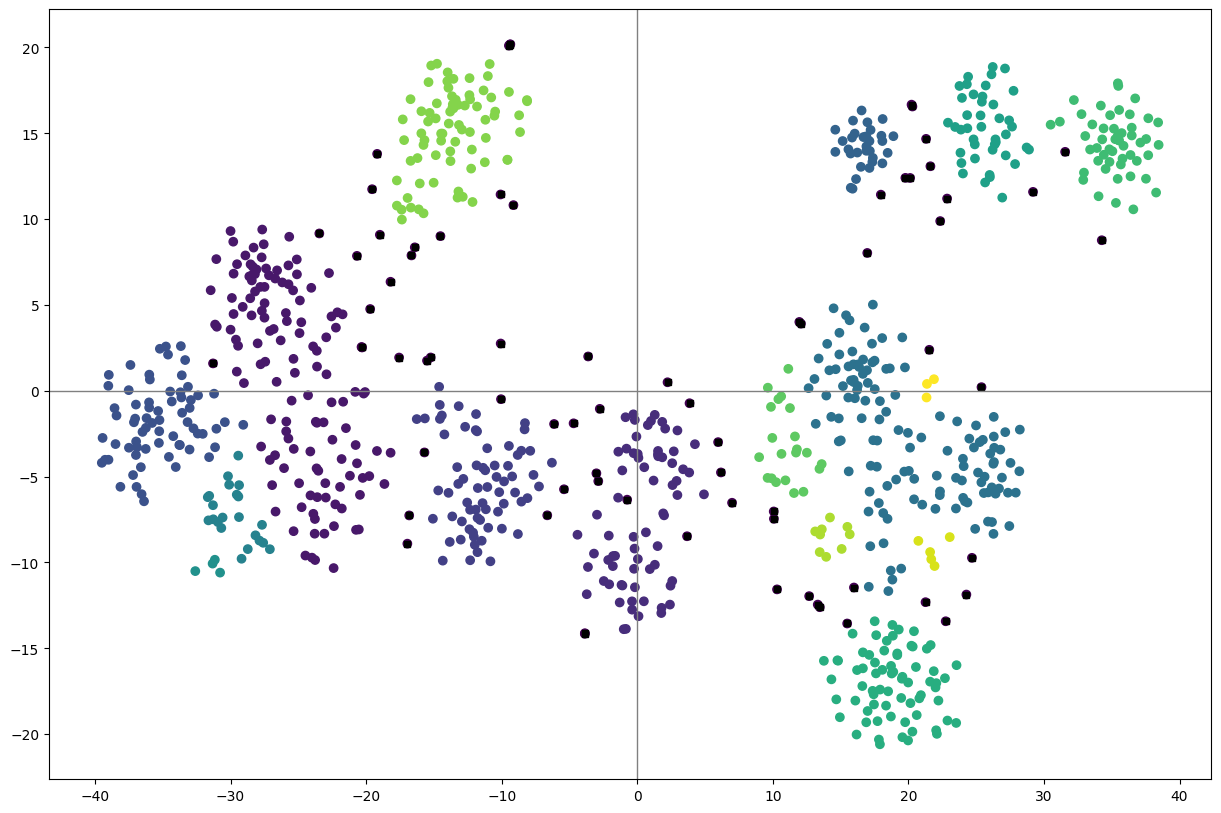

In [17]:
plt.figure(figsize=(15, 10))

dbscan = DBSCAN(eps=1.7, min_samples=4)
label = dbscan.fit_predict(tsne_results)

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=label, cmap="viridis")
plt.plot(
    tsne_results[label == -1, 0],
    tsne_results[label == -1, 1],
    "sk",
    markersize=4,
    label=-1,
)
plt.axhline(0, color="grey", lw=1)
plt.axvline(0, color="grey", lw=1)

plt.show()

Since our data has a different density, DBSCAN has a problem with clustering. Also, we have a prior domain knowledge so it is better to use other clustering methods.
